In [ ]:
# ======================================
# STEP 1 — Install dependencies
# ======================================
!pip install requests pandas tqdm matplotlib

import requests, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
# ======================================
# STEP 2 — NOAA API setup
# ======================================
NOAA_TOKEN = "MyToken"
headers = {"token": NOAA_TOKEN}
BASE_URL = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"


In [ ]:
# ======================================
# STEP 3 — Define target stations
# ======================================
stations = {
    "Tucson Intl Airport" : "GHCND:USW00023160",
    "Sells, AZ"           : "GHCND:USC00028931",
    "Green Valley, AZ"    : "GHCND:USC00023190"
}

start_year, end_year = 2010, 2023
datatypes = ["TMAX", "TMIN", "TAVG", "PRCP"]

# ======================================
# STEP 4 — Function to pull one station-year
# ======================================
def get_noaa_year(station_id, year):
    start = f"{year}-01-01"
    end   = f"{year}-12-31"
    data  = []
    offset = 1
    while True:
        params = {
            "datasetid": "GHCND",
            "stationid": station_id,
            "startdate": start,
            "enddate": end,
            "units": "standard",   # Fahrenheit/inches
            "limit": 1000,
            "offset": offset,
            "datatypeid": datatypes,
        }
        r = requests.get(BASE_URL, headers=headers, params=params)
        if r.status_code != 200:
            print(f"⚠️ {station_id} {year}: HTTP {r.status_code}")
            break
        results = r.json().get("results", [])
        if not results:
            break
        data.extend(results)
        offset += 1000
    return pd.DataFrame(data)

# ======================================
# STEP 5 — Loop through stations & years
# ======================================
dfs = []
for name, sid in stations.items():
    print(f"\n📡 Downloading {name}")
    for year in tqdm(range(start_year, end_year + 1)):
        df_year = get_noaa_year(sid, year)
        if not df_year.empty:
            df_year["station_name"] = name
            dfs.append(df_year)




📡 Downloading Tucson Intl Airport


  7%|▋         | 1/14 [00:30<06:34, 30.36s/it]

⚠️ GHCND:USW00023160 2010: HTTP 503


 71%|███████▏  | 10/14 [01:19<00:50, 12.70s/it]

⚠️ GHCND:USW00023160 2019: HTTP 503


100%|██████████| 14/14 [01:32<00:00,  6.61s/it]



📡 Downloading Sells, AZ


 79%|███████▊  | 11/14 [00:42<00:30, 10.17s/it]

⚠️ GHCND:USC00028931 2020: HTTP 503


100%|██████████| 14/14 [00:49<00:00,  3.50s/it]



📡 Downloading Green Valley, AZ


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


✅ Saved 9,182 rows to pima_climate_daily_2010_2023.csv
✅ Monthly summary saved as pima_climate_monthly_2010_2023.csv


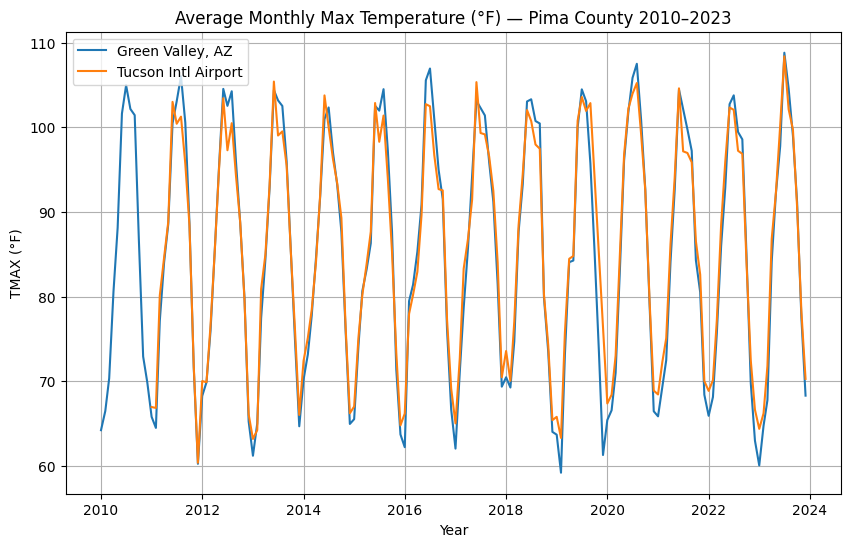

In [ ]:
# ======================================
# STEP 6 — Combine and clean
# ======================================
if dfs:
    climate = pd.concat(dfs, ignore_index=True)
    climate["date"] = pd.to_datetime(climate["date"])
    climate = (
        climate.pivot_table(index=["station_name", "date"],
                            columns="datatype", values="value")
        .reset_index()
    )
    climate.to_csv("pima_climate_daily_2010_2023.csv", index=False)
    print(f"✅ Saved {len(climate):,} rows to pima_climate_daily_2010_2023.csv")
else:
    raise ValueError("No data retrieved — check token or year range.")

# ======================================
# STEP 7 — Monthly aggregation
# ======================================
monthly = (
    climate.groupby(
        [climate["station_name"], climate["date"].dt.to_period("M")]
    )
    .agg({"TMAX": "mean", "TMIN": "mean", "TAVG": "mean", "PRCP": "sum"})
    .reset_index()
)
monthly["date"] = monthly["date"].dt.to_timestamp()
monthly.to_csv("pima_climate_monthly_2010_2023.csv", index=False)
print("✅ Monthly summary saved as pima_climate_monthly_2010_2023.csv")

# ======================================
# STEP 8 — Quick visualization
# ======================================
plt.figure(figsize=(10,6))
for name, g in monthly.groupby("station_name"):
    plt.plot(g["date"], g["TMAX"], label=name)
plt.title("Average Monthly Max Temperature (°F) — Pima County 2010–2023")
plt.xlabel("Year"); plt.ylabel("TMAX (°F)")
plt.legend(); plt.grid(True); plt.show()

In [ ]:
missing_years = [2010, 2019]

for year in missing_years:
    df_retry = get_noaa_year("GHCND:USW00023160", year)
    if not df_retry.empty:
        df_retry["station_name"] = "Tucson Intl Airport"
        climate = pd.concat([climate, df_retry])

In [ ]:
climate = (
    climate.sort_values(["station_name","date"])
            .groupby("station_name")
            .apply(lambda g: g.interpolate(method="linear"))
            .reset_index(drop=True)
)

/tmp/ipython-input-2774602452.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .apply(lambda g: g.interpolate(method="linear"))
/tmp/ipython-input-2774602452.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .apply(lambda g: g.interpolate(method="linear"))
/tmp/ipython-input-2774602452.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.interpolate(method="linear"))


In [ ]:
climate['year'] = climate['date'].dt.year
print(climate.groupby(['station_name','year']).size().unstack(fill_value=0))

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# Make sure the 'date' column exists
print(climate.columns)

# Convert to datetime
climate['date'] = pd.to_datetime(climate['date'], errors='coerce')

# Verify
print(climate['date'].dtypes)
print(climate['date'].head())

Index(['station_name', 'date', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'year',
       'datatype', 'station', 'attributes', 'value'],
      dtype='object')
datetime64[ns]
0   2010-01-01
1   2010-01-02
2   2010-01-03
3   2010-01-04
4   2010-01-05
Name: date, dtype: datetime64[ns]


✅ Saved heatwave frequency data → pima_heatwave_monthly.csv


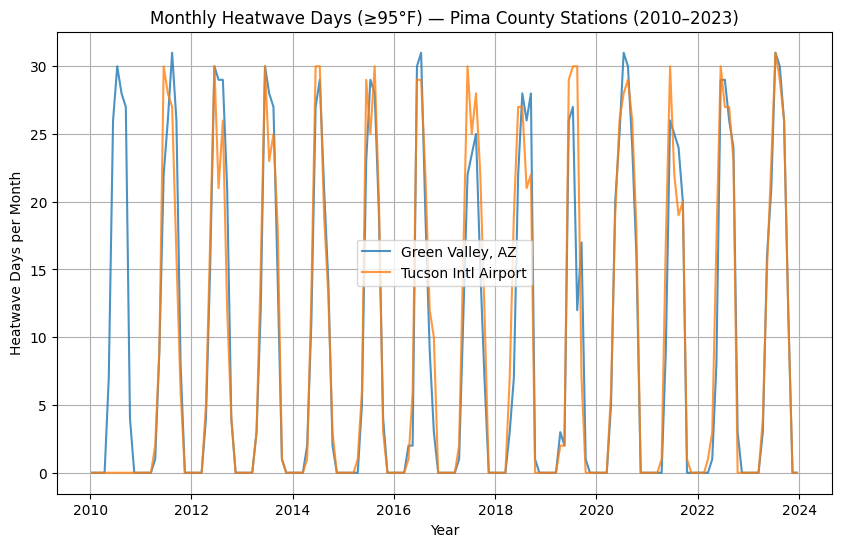

In [ ]:
# ======================================
# STEP 9 — Detect heatwave days (≥ 95°F)
# ======================================

# Define threshold
heat_threshold = 95.0

# Ensure numeric
climate["TMAX"] = pd.to_numeric(climate["TMAX"], errors="coerce")

# Mark heatwave days
climate["heatwave_day"] = (climate["TMAX"] >= heat_threshold).astype(int)

# Extract year-month
climate["year"] = climate["date"].dt.year
climate["month"] = climate["date"].dt.month

# ======================================
# STEP 10 — Aggregate monthly frequency
# ======================================
heatwave_monthly = (
    climate.groupby(["station_name", "year", "month"])
    .agg(
        avg_TMAX=("TMAX", "mean"),
        avg_TMIN=("TMIN", "mean"),
        heatwave_days=("heatwave_day", "sum"),
        precip_total=("PRCP", "sum"),
    )
    .reset_index()
)

# Save result
heatwave_monthly.to_csv("pima_heatwave_monthly.csv", index=False)
print("✅ Saved heatwave frequency data → pima_heatwave_monthly.csv")

# ======================================
# STEP 11 — Quick visualization
# ======================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for name, g in heatwave_monthly.groupby("station_name"):
    plt.plot(
        pd.to_datetime(g["year"].astype(str) + "-" + g["month"].astype(str) + "-15"),
        g["heatwave_days"],
        label=name,
        alpha=0.8,
    )

plt.title("Monthly Heatwave Days (≥95°F) — Pima County Stations (2010–2023)")
plt.xlabel("Year")
plt.ylabel("Heatwave Days per Month")
plt.legend()
plt.grid(True)
plt.show()